# cosmoDC2 Halos

This notebook demonstrates how we extracted cosmoDC2 halos from <a href='https://github.com/LSSTDESC/gcr-catalogs'> Generic Catalog Reader (GCR)</a> and computed the weak lensing signal for one of the extracted halos using <a href='https://github.com/LSSTDESC/CLMM'>Cluster weak Lensing Mass Modeling (CLMM)</a>. The notebook also compares the computed signal with theoretical output from colossus python package. In addition, we will also explore one of the popular astronomy python package, astropy.

GCR is an open source python package serving as a repository of various galaxy and sky catalogs for the LSST Dark Energy Science Collaboration (DESC). GCR offers a unified UI (User Interface) acccess to all the catalogs in the repository. CLMM is also an open source python library for estimating the weak lensing mass of clusters of galaxies and performing any related weak lensing analysis. CLMM has useful packages and functions that can easily be called to compute the weak lensing signal of the source galaxies.
 
The notebook has 3 sections:
- Loading the Catalog
- Computing the lensing signal for 1 Halo using CLMM
- Computing the lensing signal using a our own defined function (Parallelization)

**<font color='red'>NOTE</font>**<br>
Due to the size of the catalogs and collaboration purposes, the GCR catalogs have been mirrored at National Energy Research Scientific Computing Center (NERSC) and IN2P3-CC. This notebook was prepared and run in NERSC, which offers scientific computing resources. To access the NERSC computing resources you need to be in the LSST user group.


## Loading Python Packages

In [40]:
import numpy as np
import pandas as pd
import math

import clmm
import GCRCatalogs as gcr
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
from fitsio import FITS
import healpy as hp

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('presentation.mplstyle')
import warnings

path = '/global/u1/k/kamau/SE-CLMM-LSSTDESC/cosmoDC2/Data/'

We will start by loading the galaxy catalog of interest for this analysis; cosmoDC2. There are several varaiations of the catalog but this analysis will focus on the latest version and largest catalog that covers $440 ~\mathrm{deg}^2$ of sky area to a redshift of $\mathrm{z}=3$ and magnitude depth of $28$ in the r band 

## Loading comsoDC2 Catalog

In [41]:
catalog_440 = gcr.load_catalog('cosmoDC2_v1.1.4') 
#cat_load_redmapper = gcr.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.7.5') # Cluster and member catalogs computed from the redMaPPer cluster finder
print('\n'.join(sorted(c for c in gcr.get_available_catalogs(include_default_only=False) if c.startswith('cosmo'))))

cosmoDC2
cosmoDC2_v1.0
cosmoDC2_v1.0_10194_10452
cosmoDC2_v1.0_8786_9049
cosmoDC2_v1.0_9050_9430
cosmoDC2_v1.0_9431_9812
cosmoDC2_v1.0_9556
cosmoDC2_v1.0_9813_10193
cosmoDC2_v1.0_image
cosmoDC2_v1.0_image_addon_knots
cosmoDC2_v1.0_small
cosmoDC2_v1.1.4
cosmoDC2_v1.1.4_image
cosmoDC2_v1.1.4_image_addon_knots
cosmoDC2_v1.1.4_image_combined_agn
cosmoDC2_v1.1.4_image_with_photoz_calib
cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1
cosmoDC2_v1.1.4_image_with_photozs_v1
cosmoDC2_v1.1.4_parquet
cosmoDC2_v1.1.4_redmapper_v0.7.5
cosmoDC2_v1.1.4_small
cosmoDC2_v1.1.4_small_combined_agn
cosmoDC2_v1.1.4_small_combined_agn_allon
cosmoDC2_v1.1.4_small_with_photoz_SKRF_v1
cosmoDC2_v1.1.4_small_with_photoz_calib
cosmoDC2_v1.1.4_small_with_photozs_flexzboost_v1
cosmoDC2_v1.1.4_small_with_photozs_v1


Using `get_quantities()`, we extract all the cosmoDC2 halos required for this analysis. The location (`ra` and `dec`), halo id, halo mass, halo redshift and the magnification are the only selected halo properties for this analysis. The halo mass is limited to a minimum of $10^{13}$Msun, since low halo mass have low resolution and prone to systematic errors in observational surveys. The redshift of the halos is also limited between $1$ and $0.2$ since we will extract source galaxies beyond the lens redshift (halos).

We define a funtion to limit the area around every cluster where we will extract the source galaxies. The size of the box around every cluster is added as a column to the extracted table of halos. Using `astropy.write()`, we save the extracted halos as `.dat` file and read it in to proceed with the analysis.

In [42]:
gcosmology = catalog_440.cosmology
cosmo = clmm.Cosmology(H0 = gcosmology.H0.value, Omega_dm0 = gcosmology.Om0 - gcosmology.Ob0, Omega_b0 = gcosmology.Ob0)

In [43]:
# Function to generate box size around the cluster
cosmo_f = FlatLambdaCDM(H0=gcosmology.H0.value, Om0=gcosmology.Om0)
def box_size(z):
    rad_max = 30 # Change radius - 2...30
    DA = cosmo_f.angular_diameter_distance(z).value
    b_size = round(rad_max / DA * (180/np.pi), 1)
    return b_size

In [46]:
mmin = 1.e13 
zmin = 0.2
zmax = 1

# halos = Table(catalog_440.get_quantities(['ra','dec','halo_id', 'halo_mass', 'redshift_true','magnification'], 
                                 # filters=['is_central',f'halo_mass > {mmin}', f'redshift_true > {zmin}',f'redshift_true < {zmax}']))
# halos['field_size'] = [box_size(i) for i in halos['redshift_true']]
# halos.write('Data/halos-mu_0.2-1_184339.dat', format='ascii')

halos = Table.read(path+'halos/halos_0.2-1_19273.dat', format='ascii')

N_halos = len(halos['ra'])
print(f'There are {N_halos} clusters in this mass and redshift range')
halos.sort(keys='halo_mass',reverse=True)

There are 19273 clusters in this mass and redshift range


Preview of the first five cosmDC2 halos extracted

In [47]:
halos[:5]

<Table length=5>
    halo_mass              ra         ...         dec         field_size
     float64            float64       ...       float64        float64  
------------------ ------------------ ... ------------------- ----------
1896877410332845.2  50.14426461602947 ... -31.166231318709762        1.1
1699516479597611.2 62.099644926211674 ... -33.910776924385665        1.2
1505982549981386.0 53.631943677541855 ...  -34.78613843770464        1.2
1328346332168653.5  61.38091042723989 ... -39.995134303962544        1.1
1134791135658907.0  71.22669614894077 ... -45.453150757055155        1.5

Distribution of the halo mass agrees with the expected theoretical halo_mass distribution. It also shows the number of massive haloes above $1.\mathrm{e}15$ is small.

/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


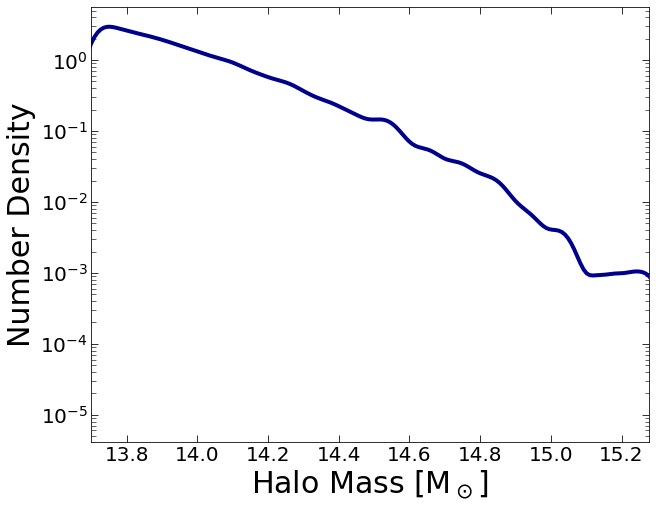

In [49]:
sns.distplot(np.log10(halos['halo_mass']), hist=False,bins=10, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.yscale('log')
plt.xlim(np.log10(halos['halo_mass'].min()),np.log10(halos['halo_mass'].max()))
plt.ylabel('Number Density')
plt.xlabel('Halo Mass [M$_\odot]$')
plt.show()

In [39]:
plt.hist(np.log10(halos['halo_mass']), density=True)
plt.yscale('log')
plt.xlabel('Halo Mass [M$_\odot]$')
plt.ylabel('Count')
plt.show()

## $\Sigma$ and $\Delta\Sigma$ for 1 Halo using CLMM

In this section we will illustrate how to compute the lensing signal of the source galaxies for 1 halo using CLMM. To consume less time during extraction of the source galaxies, we select the halo with the minimum box size. Note that to compute the lensing signal for all the extracted halos cannot be done on an interactive node due to the limited resource allocation in NERSC. Jobs were submitted to achieve this.

Observationally $\Delta\Sigma$ is less noisy than  $\Sigma$ while in simulations  $\Sigma$ is less noisy than $\Delta\Sigma$. However, $\Delta\Sigma$ can be computed from the observed shera based on the observed galaxy ellipcities while  $\Sigma$, which is computed from the convergence, is very hard to measure.

Selecting 1 halo and assigning its properties to variables for later analysis.

In [50]:
index = 0
halo1 = halos[halos['field_size']==halos['field_size'].min()]
print(halo1[0])
halo_mass, ra_cl, z_cl, halo_id,  dec_cl, field_size   = list(halo1[index])

    halo_mass             ra          redshift_true       halo_id           dec        field_size
----------------- ----------------- ------------------ ------------- ----------------- ----------
836260662338343.8 51.57828504438181 0.9667961597442627 1620800164247 -41.5431903639977        1.0


Using the defined variables associated with halo properties, we extract source galaxies for the halo id $1620800164247$. We select the location, redshift and convergence information for each galaxy.

In [51]:
# Get the source galaxies of the halo with halo_id : 1620800164247
ra_min, ra_max = ra_cl - field_size, ra_cl + field_size 
dec_min, dec_max = dec_cl - field_size, dec_cl + field_size
z_min= z_cl + 0.1

coord_filters = ['ra >= {}'.format(ra_min),'ra < {}'.format(ra_max),'dec >= {}'.format(dec_min),'dec < {}'.format(dec_max)]
z_filters = ['redshift_true >= {}'.format(z_min)]
gal_src = catalog_440.get_quantities(['ra', 'dec','redshift_true','shear_1', 'shear_2','convergence'],filters=(coord_filters + z_filters+['convergence != 0']))

length_gal = len(gal_src['ra'])
print(f'There are {length_gal} source galaxies')

There are 12781357 source galaxies


We use `.compute_tangential_and_cross_components()` which returns three components; angle of separetion ($\theta$), tangential and cross shear. CLMM uses the small angular separation approximation formula;

$$\theta = \sqrt{(\delta_s - \delta_l)^2+(\alpha_s-\alpha_l)^2 \cos^2(\delta_l)}$$

where, l is the lens (cluster) <br>
$~~~~~~~~~~$ s is the source galaxy <br>
$~~~~~~~~~~$ $\alpha$ is the `ra` <br>
$~~~~~~~~~~$ $\delta$ is the `dec` <br>

We can now use `.GalaxyCluster()` from CLMM to create the cluster object. We also add the critical surface density as columns to the cluster object. Definition of the cosmological parameters under which cosmoDC2 was simulated is required when using CLMM.

In [52]:
# Create a Galaxy Cluster and add the sigma crit and theta variables
g_wo_shpnoise = clmm.GCData([gal_src['ra'],gal_src['dec'],gal_src['redshift_true'],gal_src['shear_1'],gal_src['shear_2'],gal_src['convergence']],names=('ra','dec','z','e1','e2','kappa'))
c_wo_shpnoise = clmm.GalaxyCluster(str(halo_id), ra_cl, dec_cl, z_cl, g_wo_shpnoise)
c_wo_shpnoise.add_critical_surface_density(cosmo=cosmo)
theta, g_t, g_x = c_wo_shpnoise.compute_tangential_and_cross_components(geometry='flat')

/global/homes/k/kamau/clmmdesc/lib/python3.8/site-packages/clmm-1.3.4-py3.8.egg/clmm/dataops/__init__.py:400: UserWarning: Using the flat-sky approximation with separations >1 deg may be inaccurate


In [53]:
c_wo_shpnoise.galcat[:5]

GCData(cosmo='CCLCosmology(H0=71.0, Omega_dm0=0.21999999999999997, Omega_b0=0.0448, Omega_k0=0.0)', sigmac_type='standard', columns: ra, dec, z, e1, e2, kappa, sigma_c, theta, et, ex)

Distribution of the source galaxy's redishift. The distribution also shows the position of the cluster. 

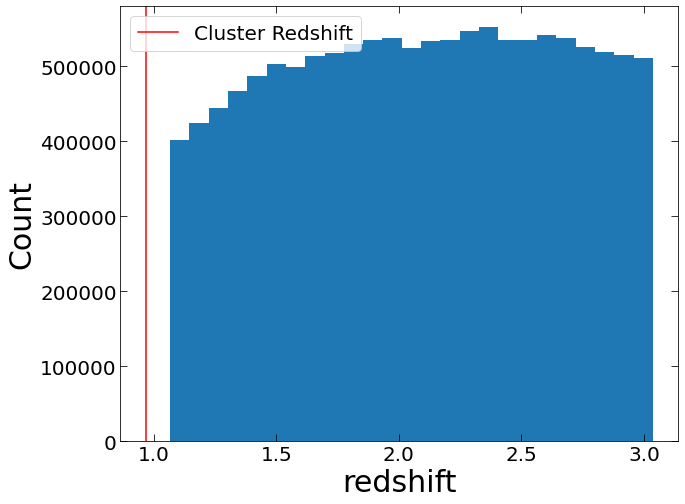

In [54]:
plt.hist(c_wo_shpnoise.galcat['z'], bins=25)
plt.axvline(c_wo_shpnoise.z, color = 'r', label = 'Cluster Redshift')
plt.legend()
plt.ylabel('Count')
plt.xlabel('redshift')
plt.show()

With the cluster object table having all the columns needed, we compute the $\Sigma$ and $\Delta\Sigma$ using the formula;

$$\Sigma = Convergence * \Sigma_{crit}$$

$$\Delta\Sigma = et * \Sigma_{crit} $$

$$\Sigma_{crit} = \frac{C^2 * \mathrm{D_s}}{4*\pi *\mathrm{G *D_l*D_{ls}}}$$

where, C is the speed of light <br>
$~~~~~~~~~~$ $\mathrm{G}$ is the gravitational constant <br>
$~~~~~~~~~~$ $\mathrm{D_s}$ is the distance from the observer to the source galaxy <br>
$~~~~~~~~~~$ $\mathrm{D_l}$ is the distance from the observer to the len <br>
$~~~~~~~~~~$ $\mathrm{D_{ls}}$ is the distance from the lens to the source galaxy <br>

To increase the signal-to-noise ratio we use CLMM function, `make_radial_profile()`, to define radial bins. This results in a table that shows the radial bins of the cluster object from the center to $30\mathrm{Mpc}$,  aggregated mean ($\Sigma$ and $\Delta\Sigma$) for each bin with its associated statistical errors, $\sigma$, and the number of source galaxies in each bin.



In [55]:
bin_edges = clmm.make_bins(0.1, 30, nbins=15, method='evenlog10width')
sigma = c_wo_shpnoise.galcat['kappa']*c_wo_shpnoise.galcat['sigma_c']
DS = c_wo_shpnoise.galcat['et']*c_wo_shpnoise.galcat['sigma_c']
sigma_bin = clmm.make_radial_profile([sigma,DS],
                         angsep=c_wo_shpnoise.galcat['theta'],angsep_units='radians',bin_units='Mpc',bins=bin_edges,cosmo=cosmo,
                         z_lens=c_wo_shpnoise.z)
sigma_bin.rename_columns(('p_0', 'p_0_err', 'p_1', 'p_1_err'), ('sigma', 'sigma_err', 'DS', 'DS_err'))
sigma_bin

GCData(cosmo=None, bin_units='Mpc', columns: radius_min, radius, radius_max, sigma, sigma_err, DS, DS_err, n_src)

Visualisation of the computed weak lensing signal for halo with `halo_id = 1620800164247`

In [56]:
plt.loglog(sigma_bin['radius'],sigma_bin['sigma'],marker='o')
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
plt.xlabel('Radius [Mpc]')
plt.show()

In [57]:
plt.loglog(sigma_bin['radius'],sigma_bin['DS'],marker='o')
plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
plt.xlabel('Radius [Mpc]')
plt.show()

## Comparing with theoretical computation
In this section we calculate the weak lensing signal theoretically using the colossus python package with an assumed cosmology. We then compare the results with the CLMM results of 10 massive halos to validate our output. Massive halos have strong weak lensing signal.

In [58]:
# Sigma of the 10 massive halos
massive_halos = pd.read_csv(path+'halos/massive_halos.csv')
massive_halos['radius'] = massive_halos.loc[:,'r1':"r15"].apply(lambda r: tuple(r), axis=1).apply(np.array)  
massive_halos['sigma'] = massive_halos.loc[:,'gt1':"gt15"].apply(lambda r: tuple(r), axis=1).apply(np.array)
massive_halos = massive_halos[['halo_id','radius','sigma']]

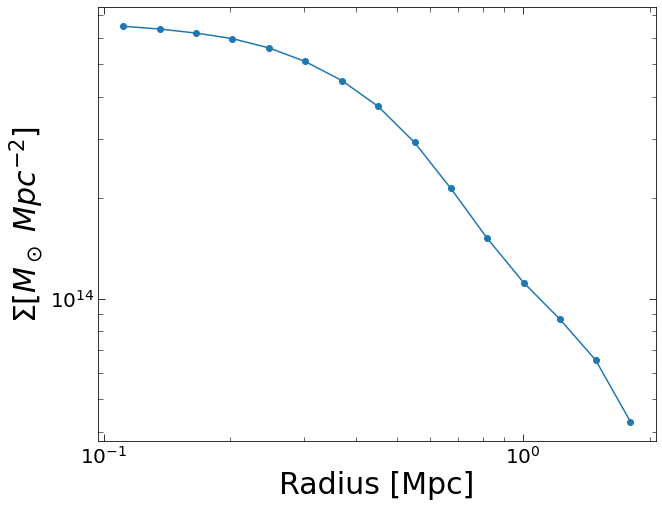

In [59]:
plt.loglog(massive_halos['radius'].mean(),massive_halos['sigma'].mean(), marker='o',label='cosmo')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
plt.show()

In [78]:
# Using colossus
from colossus.halo import profile_nfw, profile_einasto,profile_dk14
from colossus.cosmology import cosmology

params = {'flat': True, 'H0': gcosmology.H0.value, 'Om0': gcosmology.Om0 , 'Ob0': gcosmology.Ob0,
         'sigma8': gcosmology.sigma8, 'ns':gcosmology.n_s}
cosmology.setCosmology('cosmo', params)

Mvir = halos['halo_mass'][halos['halo_id']==2050900064279.0]
cvir = 4
z = 0.2

p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(2,4,0.02)
Sigma_nfw = p_nfw.surfaceDensity(r)
sigma_dk14 = p_dk14.surfaceDensity(r)
Sigma_einasto = p_einasto.surfaceDensity(r)

# plt.xlabel('r(Mpc/h)')
# plt.ylabel('surface density')
# plt.loglog(r/1.e3, Sigma_nfw*1.e6, '-', label = 'NFW')
# plt.loglog(r/1.e3, sigma_dk14*1.e6, '-', label = 'DK14')
# plt.loglog(r/1.e3, Sigma_einasto*1.e6, '-', label = 'Einasto')
# plt.legend()

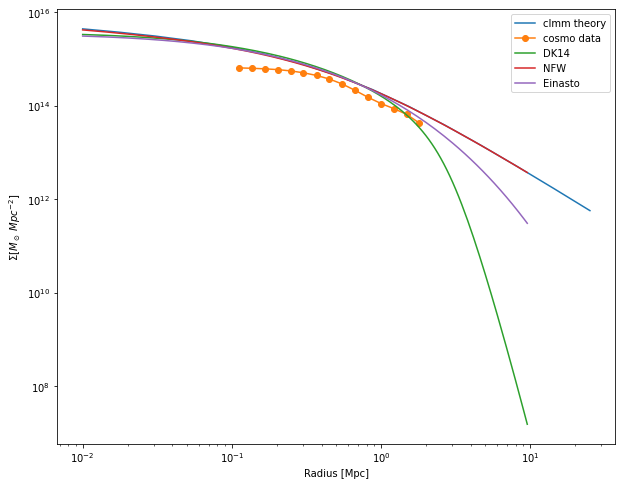

In [77]:
# CosmoDC2 theory (clmm-theory) and CosmoDC2 plot (clmm-fundtions) and colossus
r3d = np.logspace(-2, 1.4, 15)
plt.figure(figsize=(10,8))
sigma_theory = clmm.compute_surface_density(r3d,mdelta = halos['halo_mass'][0],cdelta=4,z_cl=halos['redshift_true'][0],cosmo=cosmo)
plt.loglog(r3d,sigma_theory, label='clmm theory')
plt.loglog(massive_halos['radius'].mean(),massive_halos['sigma'].mean(), marker='o',label='cosmoDC2 data')
plt.loglog(r*1e-3, sigma_dk14*1.e6, '-', label = 'DK14')
plt.loglog(r*1e-3, Sigma_nfw*1.e6, '-', label = 'NFW')
plt.loglog(r*1e-3, Sigma_einasto*1.e6, '-', label = 'Einasto')
plt.xlabel("Radius [Mpc]")
plt.ylabel('$\Sigma [M_\odot\; Mpc^{-2}]$')
lgd = plt.legend()
plt.show()

The plot shows our computation using CLMM is consistent with the theoretical results.

## Reading fits file

This file contains the comupted lensing signal of $5250$ halos.

The results of the submitted jobs was saved as fits file. Below we read the results of one of the halos, which is a row in the fits file.

In [60]:
ds_wo_shpnoise = FITS(path+'clmm_data/ds_wo_shpnoise_0.2-1_5250.fits', mode=0)  
print(len(ds_wo_shpnoise))
# xtname_list = [int(ds_wo_shpnoise[i].get_extname()) for i in range(1,len(ds_wo_shpnoise))]
Table(ds_wo_shpnoise[2].read())
# ds_wo_shpnoise

5250


<Table length=15>
     radius_min            radius       ...         z_err           n_src  
      float64             float64       ...        float64          int64  
------------------- ------------------- ... ---------------------- --------
                0.1 0.12471627390186571 ...   0.020185402032362836     1240
0.14626533728893854 0.18226955030578273 ...   0.013603036296795363     2601
0.21393548892246955 0.26654044404394767 ...    0.00923545163394763     5530
 0.3129134644531899  0.3888711999990196 ...   0.006409216722787952    11813
0.45768393420496095  0.5710765597583575 ...   0.004368676364331113    25217
 0.6694329500821696  0.8341363802037133 ...  0.0030004665831980886    54199
 0.9791483623609771   1.219838782440936 ...   0.002027255484722383   117203
 1.4321546547664015  1.7847182868655689 ...  0.0013937565557526166   249452
 2.0947458362933102  2.6106960624418623 ...  0.0009541107880462885   535112
  3.063887062800406   3.818415203131745 ...  0.0006515313032775123  1149689
  4.481404746557166   5.587525371375489 ...  0.0004429167881379925  2487660
  6.554741767834343   8.162543225733387 ...  0.0003034733760041658  5320796
  9.587315155141832   11.94398743371725 ... 0.00020840294882234472 11290308
 14.022918848621721   17.38878659430122 ... 0.00014505749633350333 23235298
 20.510669551690707  24.921649460640662 ... 0.00012196305681129473 32935341

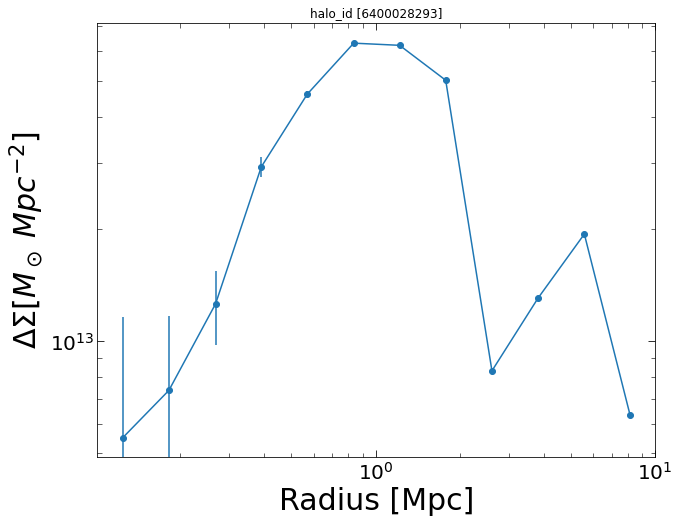

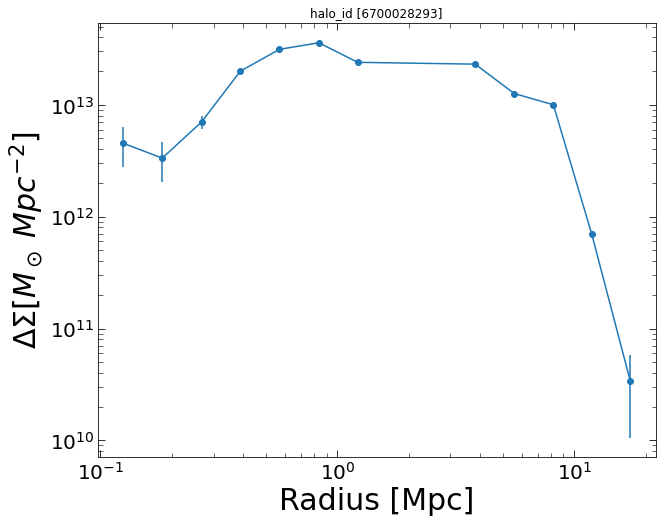

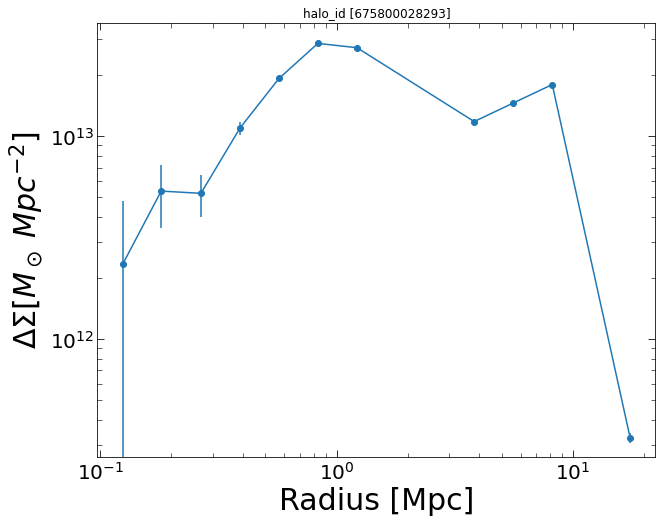

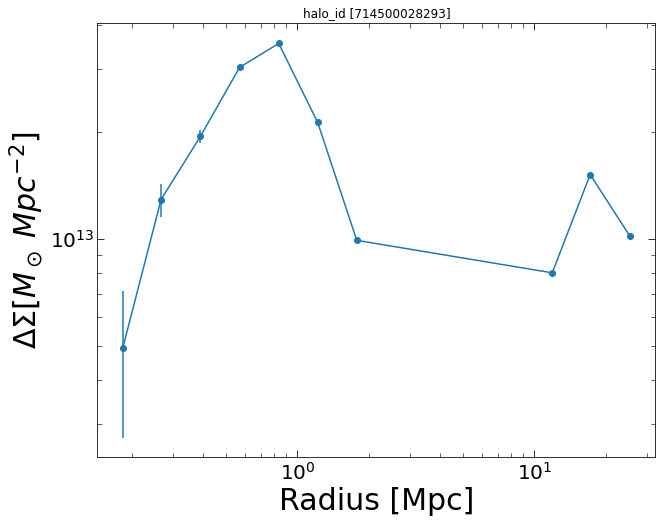

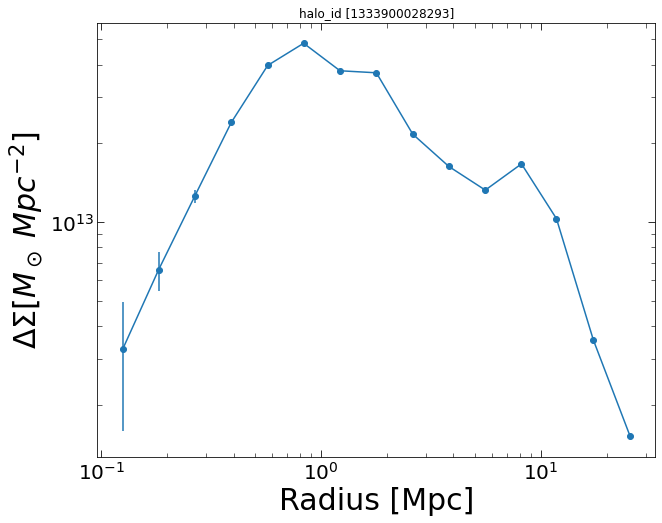

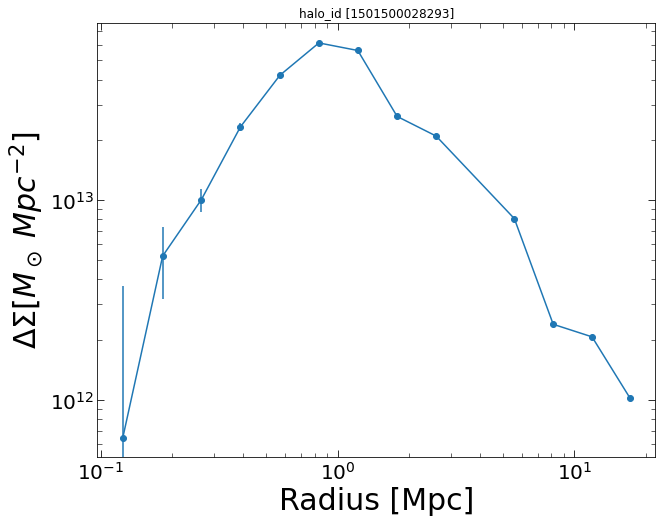

In [61]:
for i in range(1000,1010):
    wo_shpnoise = Table(ds_wo_shpnoise[i].read())
    wo_shpnoise = wo_shpnoise[wo_shpnoise['gt']>0]
    plt.errorbar(wo_shpnoise['radius'], wo_shpnoise['gt'],wo_shpnoise['gt_err'],marker='o', label='Without ShapeNoise')
    plt.title('halo_id [{}]'.format(ds_wo_shpnoise[i].get_extname()))
    plt.xlabel("Radius [Mpc]")
    plt.ylabel('$\Delta\Sigma [M_\odot\; Mpc^{-2}]$')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
ds_wo_shpnoise.close()

In [62]:
ds_wo_shpnoise.close()

## Function to compute lensing measurements

CLMM supports the weak lensing analysis of one cluster at a time and extraction of the source galaxies consumes more time. To speed up the analysis, we customize our own function. The cosmoDC2 data is divided into a set of files based on HEALPix (Hierarchical Equal Area isoLatitude Pixelization) pixelization algorithm. There is a total of 131 pixels associated with cosmoDC2 catalog. When using CLMM, it extracts the source galaxies for each cluster separately. To speed it up, we extract all the source galaxies of one pixel and its neighbours at a time. We use `.available_healpix_pixels()` to get all the cosmoDC2 pixel ids and python package `healpy` to get all the neighbouring pixel ids of each pixel.

For each pixel, we extract all the cluster located in it. We then find the neighbours of the pixel and extract all the source galaxies. To further speed it up we make use of the python parallelizing package, `multiprocessing`.

We start by getting the list of all the pixel ids

In [63]:
# Get the neighbouring pixels 
hpix_list = catalog_440.available_healpix_pixels   # Load all the available pixels of cosmoDC2 catalog
hpix = hpix_list[0] # One pixel
hpix_neighbors = hp.pixelfunc.get_all_neighbours(32, hpix)  # Neighboring pixels
hpix_toread = list(set(hpix_list) & set(hpix_neighbors)) + [hpix]
print(hpix, '\n' ,hpix_list)

8786 
 [8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8913, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9425, 9426, 9427, 9428, 9429, 9430, 9431, 9432, 9433, 9434, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9937, 9938, 9939, 9940, 9941, 9942, 9943, 9944, 9945, 9946, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10193, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10202, 10321, 10322, 10323, 10324, 10325, 10326, 10327, 10328, 10329, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452]


Then loop through each pixel to extract the source galaxies and assign each property array to a variable name

In [ ]:
# Get all the source galaxies in the hpix_toread
ra_gal = []
dec_gal = []
z_gal = []
kappa = []
shear1 = []
shear2 = []

## getting galaxies
for hpix_i in hpix_toread:
    galaxy_data = catalog_440.get_quantities(['ra', 'dec', 'redshift_true', 'convergence', 'shear_1', 'shear_2'], filters=['convergence != 0'],  native_filters=f'healpix_pixel == {hpix_i}')
    ra_gal.extend(galaxy_data['ra'])
    dec_gal.extend(galaxy_data['dec'])
    z_gal.extend(galaxy_data['redshift_true'])
    kappa.extend(galaxy_data['convergence'])
    shear1.extend(galaxy_data['shear_1'])
    shear2.extend(galaxy_data['shear_2'])

ra_gal = np.array(ra_gal)
dec_gal = np.array(dec_gal)
z_gal = np.array(z_gal)
kappa = np.array(kappa)
shear1 = np.array(shear1)
shear2 = np.array(shear2)
chi_s = cosmo_f.comoving_distance(z_gal).value
print('Number of source galaxies',len(ra_gal))

We can now extract all the clusters located in the central pixel

In [65]:
# getting the halos
cluster_data = Table(catalog_440.get_quantities(['ra', 'dec', 'halo_mass', 'halo_id', 'redshift_true'], \
                                filters=['is_central', 'halo_mass > 1e13', 'redshift_true > 0.2', 'redshift_true < 1'],  native_filters=f'healpix_pixel == {hpix}'))
print(len(cluster_data['ra']))
cluster_data[:2]

1497


<Table length=2>
        ra            redshift_true    ...     halo_mass     
     float64             float64       ...      float64      
------------------ ------------------- ... ------------------
 49.93400119682216 0.20415878295898438 ... 170601483884169.03
50.177506675114664 0.20774507522583008 ...  39585498518715.49

Now that we have all the required catalogs to compute the lensing signal, we can write the user defined function to compute the signal using the same mathematical formula as the clmm. 

In [66]:
%%time
def run_halo_i(ihalo):   
    haloid = haloid_list[ihalo]
    ra_cl = cluster_data['ra'][ihalo]
    dec_cl = cluster_data['dec'][ihalo]
    m = cluster_data['halo_mass'][ihalo]
    z_cl = cluster_data['redshift_true'][ihalo]

    sel = (z_gal > z_cl + 0.01) & (z_gal < 2 * z_cl)  # Filter source galaxy using redshift
    ra_gal_sel = ra_gal[sel] 
    dec_gal_sel = dec_gal[sel]
    chi_s_sel = chi_s[sel]  # Comomving distance from the observer to the source

    c1 = SkyCoord(ra_gal_sel, dec_gal_sel, unit='degree')
    c2 = SkyCoord(ra_cl, dec_cl, unit='degree')
    sep = c1.separation(c2).degree  # Angle of separation between the cluster and source galaxy

    pa = c1.position_angle(c2).rad
    chi_l = cosmo.comoving_distance(z_cl).value # Comoving distance from the observer to the lens


    Sigma_crit = c**2 /(4 * np.pi* G) * chi_s_sel * (1+ z_cl) / chi_l / (chi_s_sel - chi_l) # Multiply by (1+ z_cl) to convert distance to physical units

    w = Sigma_crit**(-2)  # Weights
    Sigma = kappa[sel] * Sigma_crit 

    gammat = + shear1[sel] * np.cos(-2*pa) - shear2[sel] * np.sin(-2*pa)  # et / tangential shear
    DS = gammat * Sigma_crit

    rp = sep * np.pi / 180. * chi_l / (1 + z_cl)

    # making profiles
    nbins = 15
    rp_bins = np.logspace(-1, 1.8, nbins+1) # pMpc
    mean_Sigma = np.zeros(nbins)
    mean_rp = np.zeros(nbins)
    mean_DS = np.zeros(nbins)
    for ibin in range(nbins): # Radial binning
        sel = (rp > rp_bins[ibin])&(rp <= rp_bins[ibin+1])
        mean_Sigma[ibin] = np.sum(Sigma[sel]*w[sel])/np.sum(w[sel])
        mean_rp[ibin] = np.sum(rp[sel]*w[sel])/np.sum(w[sel])
        mean_DS[ibin] = np.sum(DS[sel]*w[sel])/np.sum(w[sel])

    df1 = pd.read_pickle('s_ds11.csv')
    dataa = np.array([haloid, mean_rp, mean_Sigma, mean_DS])
    df2 = pd.DataFrame([dataa.tolist()],columns=['halo_id','radius','sigma','DS'])
    s_ds6 = pd.concat([df1,df2])
    s_ds6.to_pickle('s_ds11.csv')

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11 µs
